In [1]:
from matplotlib import pyplot as plt
from matplotlib import collections as mc
import numpy as np

from scipy.stats import chi2

from sklearn import cluster
from sklearn import metrics

In [2]:
seed = 42  # for reproducablity

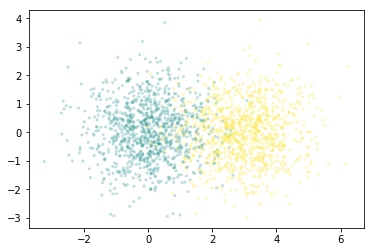

In [3]:
# sample from an equal mixture of two gaussians

np.random.seed(seed)

n_per_cluster = 1000
offset = np.array([3, 0])

X = np.concatenate([
    np.expand_dims(offset / 2, 0),  # symmetry point
    np.random.normal(size=(n_per_cluster, 2)),
    np.random.normal(size=(n_per_cluster, 2)) + offset,
])

Y = np.array([-1]
             + [0] * n_per_cluster
             + [1] * n_per_cluster)

plt.scatter(*X.T, s = 5.0, alpha = 0.2, c=Y)
plt.show()

In [4]:
# rough estimate how many neighbors near 0, 0
epsilon = 0.75
n_per_cluster * chi2.cdf(epsilon, 2)

312.7107212090279

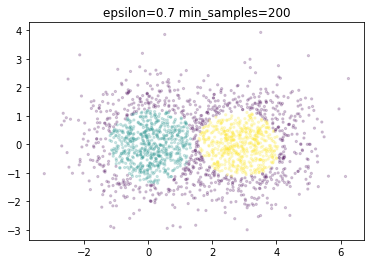

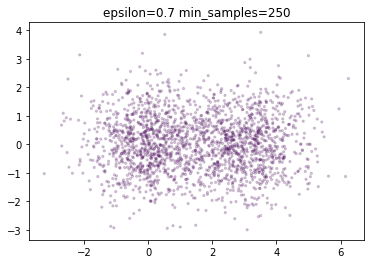

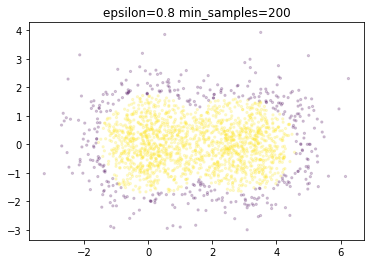

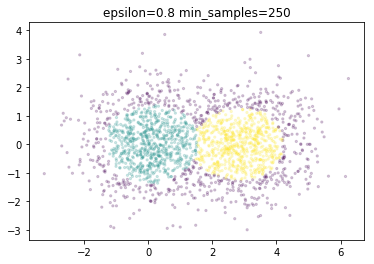

In [5]:
# two failure modes:
#     no core points (panel 2) --> turn epsilon up or min_samples down
#     clusters merge (panel 3) --> turn epsilon down or min_samples_up

def show_dbscan_2d(X, epsilon, min_samples, labels=None):
    """Performs clustering with DBSCAN on 2D euclidean data
    and plots the result. If given labels, returns the
    confusion matrix between the labels and the clusters.
    """
    dbscan = cluster.DBSCAN(eps=epsilon, min_samples=min_samples)
    Y_ = dbscan.fit_predict(X)

    title = 'epsilon={epsilon} min_samples={min_samples}'
    title = title.format(epsilon=epsilon, min_samples=min_samples)
    plt.title(title)
    plt.scatter(*X.T, s = 5.0, alpha = 0.2, c=Y_)
    plt.show()
    
    if labels is not None:
        return metrics.confusion_matrix(labels, Y_)
    

confusion_matrix = show_dbscan_2d(X, 0.7, 200, Y)
show_dbscan_2d(X, 0.7, 250)
show_dbscan_2d(X, 0.8, 200)
show_dbscan_2d(X, 0.8, 250)

In [6]:
# remarks:
#     finds two clusters
#     marks the symmetry point as an outlier
#     less than half are outliers
#     about 95% accurate on non-outliers

confusion_matrix

array([[  1,   0,   0],
       [384, 588,  28],
       [468,  31, 501]])

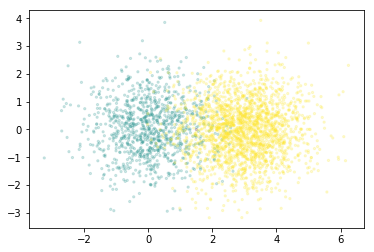

In [7]:
# now let's be mean
# sample from an imbalanced mixture of two gaussians

np.random.seed(seed)

n_per_cluster_a = 1000
n_per_cluster_b = 2000
offset = np.array([3, 0])

X_imb = np.concatenate([
    np.expand_dims(offset / 2, 0),
    np.random.normal(size=(n_per_cluster_a, 2)),
    np.random.normal(size=(n_per_cluster_b, 2)) + offset,
])

Y_imb = np.array([-1]
             + [0] * n_per_cluster_a
             + [1] * n_per_cluster_b)

plt.scatter(*X_imb.T, s = 5.0, alpha = 0.2, c=Y_imb)
plt.show()

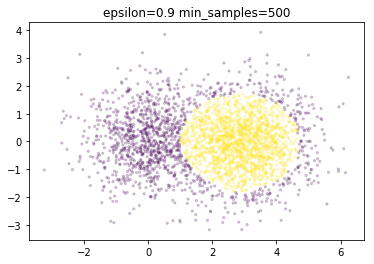

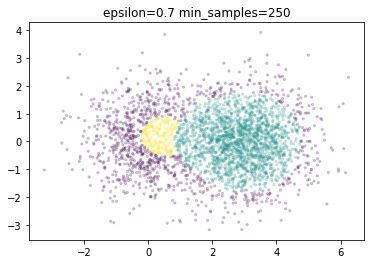

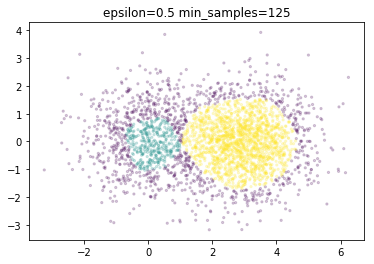

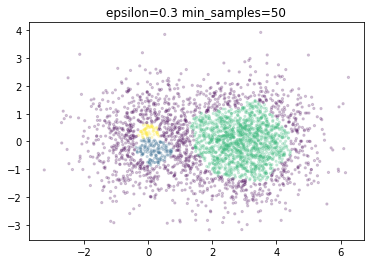

In [8]:
# two more failure modes:
#     fails to find a cluster (pannel 1) --> decrease epsilon or min_samples
#     subdivides a cluster (pannel 4) --> decrease epsilon or min_samples

show_dbscan_2d(X_imb, 0.9, 500)
show_dbscan_2d(X_imb, 0.7, 250)
confusion_matrix = show_dbscan_2d(X_imb, 0.5, 125, Y_imb)
show_dbscan_2d(X_imb, 0.3, 50)

In [9]:
# remarks
#     can find two clusters
#     but prefers to assign points to the denser cluster

confusion_matrix

array([[   0,    0,    1],
       [ 575,  335,   90],
       [ 467,   26, 1507]])

In [10]:
# obviously, in an unspervised setting, no way to know about imbalanced data a priori
#     if you did have labels, you could resample
# can look at local density estimates around cluster centroids to get more insight

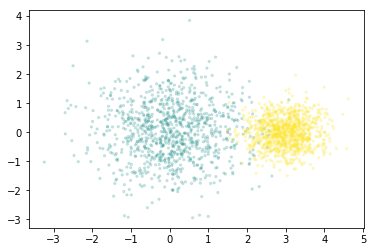

In [11]:
# alternative meanness
# clusters have the same size, but different densities

np.random.seed(seed)

n_per_cluster = 1000
offset = np.array([3, 0])

X_het_sked = np.concatenate([
    np.expand_dims(offset / 2, 0),
    np.random.normal(size=(n_per_cluster, 2)),
    np.random.normal(size=(n_per_cluster, 2)) * 0.5 + offset,
])

Y_het_sked = np.array([-1]
                      + [0] * n_per_cluster
                      + [1] * n_per_cluster)

plt.scatter(*X_het_sked.T, s = 5.0, alpha = 0.2, c=Y_het_sked)
plt.show()

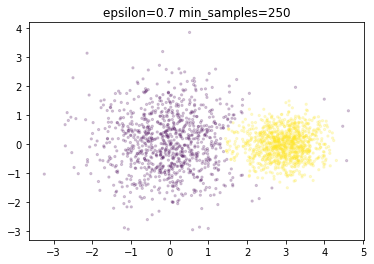

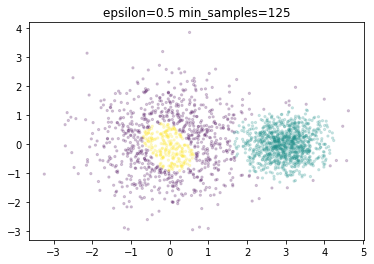

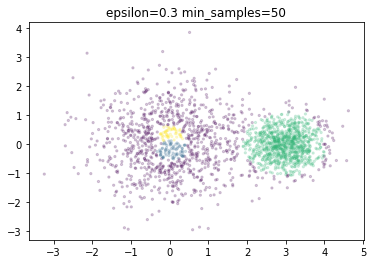

In [12]:
# similar failure modes as the imbalanced case

show_dbscan_2d(X_het_sked, 0.7, 250)
show_dbscan_2d(X_het_sked, 0.5, 125)
show_dbscan_2d(X_het_sked, 0.3, 50)

In [13]:
# how it works

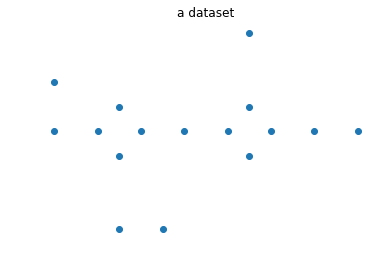

In [14]:
point_list = [
    [-3, 0],
    [-3, 1],
    [-2, 0],
    [-1.5, -2],
    [-1.5, -0.5],
    [-1.5, 0.5],
    [-1, 0],
    [-0.5, -2],
    [0, 0],
    [1, 0],
    [1.5, -0.5],
    [1.5, 0.5],
    [1.5, 2],
    [2, 0],
    [3, 0],
    [4, 0]
]

points = np.array(point_list, dtype=np.float32)
plt.scatter(*points.T)

title = 'a dataset'
plt.title(title)
plt.axis('off')
plt.show()

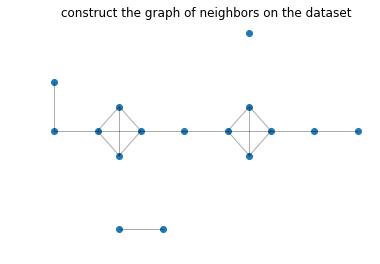

In [15]:
def list_neighboring_points(point_list, epsilon):
    neighbors = []
    for i, p1 in enumerate(point_list):
        for j, p2 in enumerate(point_list):
            if i >= j:
                continue
            x1, y1  = p1
            x2, y2 = p2
            dist_sq = (x1 - x2) ** 2 + (y1 - y2) ** 2
            if dist_sq <= epsilon ** 2:
                neighbors.append([tuple(p1), tuple(p2)])
    return neighbors


def make_lines(neighbors, linewidths=1):
    return mc.LineCollection(
        neighbors, linewidths=linewidths,
        color = np.array([0, 0, 0, 0.33])
    )

epsilon = 1.0
neighbors = list_neighboring_points(point_list, epsilon) 

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.add_collection(make_lines(neighbors))
ax.scatter(*points.T)

title = 'construct the graph of neighbors on the dataset'
plt.title(title)
plt.axis('off')
plt.show()

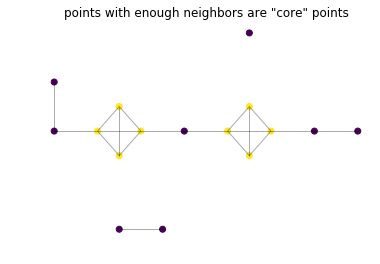

In [16]:
min_samples = 4

dbscan = cluster.DBSCAN(eps=epsilon, min_samples=min_samples)
y_ = dbscan.fit_predict(points)

c = np.zeros(len(points))
c[dbscan.core_sample_indices_] = 1

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.add_collection(make_lines(neighbors))
ax.scatter(*points.T, c=c)

title = 'points with enough neighbors are "core" points'
plt.title(title)
plt.axis('off')
plt.show()

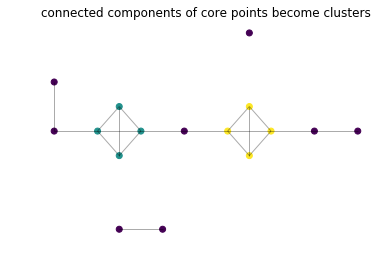

In [17]:
c = np.zeros(len(points)) - 1
c[dbscan.core_sample_indices_] = y_[dbscan.core_sample_indices_]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.add_collection(make_lines(neighbors))
ax.scatter(*points.T, c=c)

title = 'connected components of core points become clusters'
plt.title(title)
plt.axis('off')
plt.show()

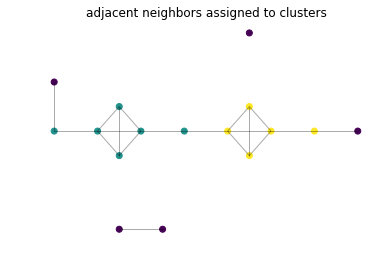

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.add_collection(make_lines(neighbors))
ax.scatter(*points.T, c=y_)

title = 'adjacent neighbors assigned to clusters'
plt.title(title)
plt.axis('off')
plt.show()

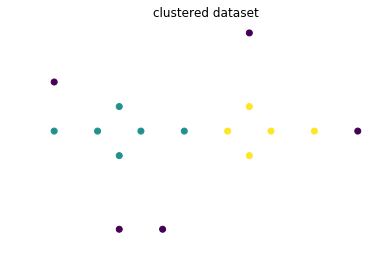

In [19]:
title = 'clustered dataset'
plt.title(title)
plt.scatter(*points.T, c=y_)
plt.axis('off')
plt.show()